In [1]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.cm as cm
from itertools import cycle

In [2]:
from sklearn import cluster
from sklearn import metrics
from sklearn import mixture

In [3]:
pathx = "/media/artemk/Data/Udacity/DS/Blog_post/LCP_extract_v4.1_xlsx.xlsx"
names = 0

In [4]:
def data_uploader(path, sheet_names):
    """
    Uploader function to create a pandas dataframe from a xlsx files of EEA
    Input: xlsx files with multiple sheets
    Output: pandas df for one specific country without redundant columns
    """
    df = pd.read_excel(io=path, sheet_name = sheet_names)
    df = df[df.MemberState == "NL"]
    df.reset_index(inplace=True, drop=True)
    df.drop(['MemberState','PlantName','OtherSector'], axis=1, inplace=True)
    return df

In [5]:
df1 = data_uploader(path=pathx, sheet_names=names)

In [6]:
df1.head()

,ReferenceYear,Plant_ID,MWth,Biomass,OtherSolidFuels,LiquidFuels,NaturalGas,OtherGases,SO2,NOx,Dust,Refineries
0,2004,NL0003,63.0,0.0,0.00,0.0,549.840,0.000,0.035,32.538,0.209,False
1,2004,NL0004,126.0,0.0,693.72,0.0,2202.520,0.000,0.140,170.000,1.942,False
2,2004,NL0005,61.0,0.0,0.00,0.0,319.574,0.117,0.000,18.967,0.000,False
3,2004,NL0006,60.0,0.0,0.00,0.0,484.807,10763.132,0.000,77.075,0.000,False
4,2004,NL0007,207.0,0.0,0.00,0.0,5362.684,167.193,0.000,275.672,0.000,False


In [7]:
"""
Let's check if the selection of power plants is the same for all years
"""
for x in range(13):
    dfx = data_uploader(path=pathx, sheet_names=x)
    print (len(dfx.index))

142
145
173
196
196
195
201
192
207
213
216
212
274


In [8]:
"""
Selecting particular sheets (i.e. years)
""" 
sheet_numbers = [3,4,5,6,7,8,9,10,11]
#not including 2016, because it is different - the statistics gathered under another law
#not including years before 2017 due to small number of plants

In [9]:
def plant_change_notifier(path, sheets):
    """
    Determining the codes of plants that are present in data for all years
    Input: xlsx files with multiple sheets
    Output: array with codes of plants of interest
    """
    df_first = data_uploader(path, sheets[0])
    initial_plants_names = set(df_first['Plant_ID'].unique())
    for sheet in sheets[1:]:
        dfx = data_uploader(path, sheet)        
        plant_names = dfx['Plant_ID'].unique()
    steady_plants_names = set(plant_names).intersection(initial_plants_names)
    return list(steady_plants_names)

In [10]:
plants = plant_change_notifier(path=pathx, sheets=sheet_numbers)

In [11]:
#plants= list(plants)

In [12]:
len(plants)

151

In [13]:
def dataframe_creator(path, sheets, plants):
    """
    Creating the hierarchial pandas dataframe
    Input:xlsx files with multiple sheets, list of plants from plant_change_notifier
    Output: Hierachial df, arranged by plant IDs (level 0) and years (level 1)
    """
    frames = []
    for sheet in sheets:
        df_prov = data_uploader(path, sheet)       
        frames.append(df_prov)
    df = pd.concat(frames, ignore_index=True, axis=0)
    df.drop(['MemberState2','ReferenceYear3'], axis=1, inplace=True)
    df = df[['Plant_ID','ReferenceYear', 'MWth',"NaturalGas", "OtherGases", 'Biomass',
             'OtherSolidFuels','LiquidFuels', 'Refineries','NOx','SO2','Dust']]
    df.sort_values(by=['Plant_ID','ReferenceYear'], inplace=True)
    df=df[df.Plant_ID.str.contains('|'.join(plants))]
    
    assert len(plants)== len(df.Plant_ID.unique().tolist())
    
    df.set_index(['Plant_ID', 'ReferenceYear'], inplace=True)
    
    return df

In [14]:
df_plants = dataframe_creator(path=pathx, sheets=sheet_numbers, plants=plants)

/home/artemk/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [15]:
df_plants.head()

MWth  NaturalGas  OtherGases  Biomass  \
Plant_ID ReferenceYear                                          
NL0003   2007           63.0  109.599994  412.897987      0.0   
         2009           63.0  148.526012  252.870710      0.0   
         2010           63.0   90.233011  390.879550      0.0   
         2011           63.0  118.514818  310.085280      0.0   
         2012           63.0  140.987014  290.625000      0.0   

                        OtherSolidFuels  LiquidFuels  Refineries     NOx  SO2  \
Plant_ID ReferenceYear                                                          
NL0003   2007                       0.0          0.0       False  35.549  0.0   
         2009                       0.0          0.0       False  13.146  0.0   
         2010                       0.0          0.0       False  13.472  0.0   
         2011                       0.0          0.0       False  12.000  0.0   
         2012                       0.0          0.0       False   7.689  0.0   

                          Dust  
Plant_ID ReferenceYear          
NL0003   2007           0.0000  
         2009           0.0235  
         2010           0.0760  
         2011           0.0677  
         2012           0.0679

In [16]:
"""
Plotting each series of pollutant.
Also good eample of power of multiindex dataframes
"""
df_plants.reset_index().pivot('Plant_ID','ReferenceYear','NOx').plot( title='NOx', grid=True)
plt.ylabel('Emissions (tons)')
df_plants.reset_index().pivot('Plant_ID','ReferenceYear','SO2').plot( title='SO2', grid=True)
plt.ylabel('Emissions (tons)')
df_plants.reset_index().pivot('Plant_ID','ReferenceYear','Dust').plot( title='Dust', grid=True)
plt.ylabel('Emissions (tons)')

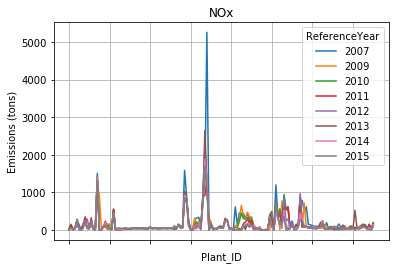

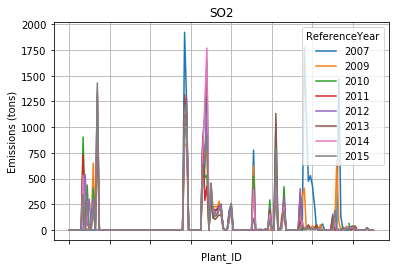

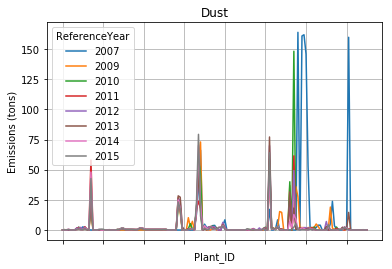

In [17]:
plt.show()

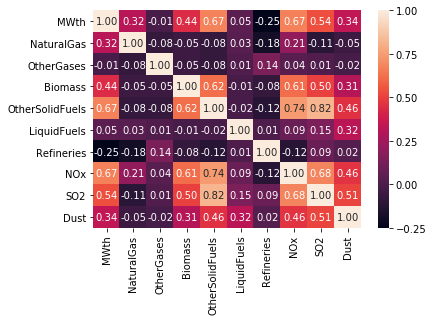

In [18]:
"""
Plant correlation matrix
"""
sns.heatmap(df_plants.corr(), annot=True, fmt=".2f")
plt.show()

In [19]:
def pollution_change_spotter_years(dfx, threshold):
    """
    Calculate amount of power plants per year, whose pollution in a given year was more than in 2015.
    Input: multiindex dataframe created earlier, threshold value for comparison with 2015 - by default 1.
    Output: regular dataframe
    """
    dfx = dfx[["NOx", "SO2", "Dust"]].copy()
    dfx = dfx.groupby(level=0).apply(lambda x : x.iloc[-1]/x).replace(0,np.nan) #if result of lambda x >1 -> polluted less than in 2015
    df_changed_years = dfx[dfx < threshold] #selecting plants which polluted more than in 2015
    df_changed_years = len(dfx.groupby(level=0)) - df_changed_years.groupby(level=1).apply(lambda x: x.isna().sum(axis=0)) -1#number of polluted more
    df_changed_years.drop(df_changed_years.tail(1).index,inplace=True)
    return df_changed_years

In [20]:
change_intime = pollution_change_spotter_years(dfx=df_plants, threshold=1)

In [21]:
change_intime

,NOx,SO2,Dust
ReferenceYear,,,
2007,92,26,27
2009,94,36,42
2010,99,32,73
2011,95,32,69
2012,85,34,68
2013,89,31,54
2014,69,29,67


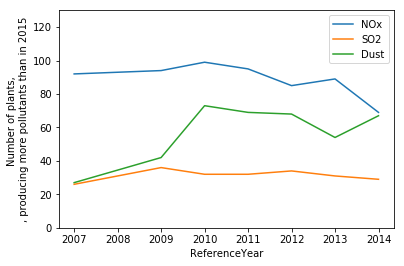

In [41]:
change_intime.plot()
plt.ylim(0, 130)
plt.ylabel('Number of plants, \n, producing more pollutants than in 2015')
plt.show()

In [23]:
def pollution_change_spotter_plants(dfx, threshold):
    """
    Calculate amount of pollutant-years per each plant from 2007 to 2015.
    Pollutant-year - a relative measure of power plant performance. One pollutant year corresponds to a (one) year
    when the particular emissions were higher than in 2015.
    Input: multiindex dataframe created earlier, threshold value for comparison with 2015 - by default 1.
    Output: regular dataframe
    """
    dfx = dfx[["NOx", "SO2", "Dust"]].copy()
    dfx = dfx.groupby(level=0).apply(lambda x : x.iloc[-1]/x)
    df_changed_plants = dfx[dfx < threshold] #selecting plants which polluted more than in 2015
    df_changed_plants = df_changed_plants[~df_changed_plants.index.isin(["2015"], level=1)] #dropping 2015
    df_changed_plants = len(dfx.groupby(level=1))-df_changed_plants.groupby(level=0).apply(lambda x: x.isna().sum(axis=0)) -1 #number of more polluted years than 2015
    
    return df_changed_plants

In [24]:
change_inplants = pollution_change_spotter_plants(dfx=df_plants, threshold=1)

In [25]:
change_inplants

,NOx,SO2,Dust
Plant_ID,,,
NL0003,4,0,2
NL0004,5,0,3
NL0005,7,0,0
NL0006,1,0,1
NL0007,6,0,0
NL0009,5,0,0
NL0010,5,0,0
NL0014,7,5,6
NL0017,2,5,4


In [26]:
def plant_scorer(df):
    """
    Summing up and cleaning the dataframe from pollution_change_spotter_plants.
    Score = total amount of pollutant-year per plant, i.e. the higher score means more variable performance
    of the power plant.
    Input: regular dataframe
    Output: regular dataframe
    """
    df['Score'] = df.sum(axis=1)
    df['MWth'] = df_plants['MWth'].groupby(level=0).median()
    df = df.drop(["NOx", "SO2", "Dust"], axis=1)
    return df

In [27]:
plant_score = plant_scorer(change_inplants)

In [28]:
plant_score

,Score,MWth
Plant_ID,,
NL0003,6,63.0
NL0004,8,126.0
NL0005,7,61.0
NL0006,2,60.0
NL0007,6,207.0
NL0009,5,139.0
NL0010,5,73.7
NL0014,18,86.4
NL0017,11,191.0


In [29]:
"""
Finding the optimal number of clusters for the model
"""

for possible_clusters_number in range(2,20):
    clusterer = cluster.KMeans(n_clusters=possible_clusters_number, random_state=0).fit(plant_score)
    preds = clusterer.predict(plant_score)
    score = metrics.silhouette_score(plant_score, preds)
    print ("For n_clusters =", possible_clusters_number,"the average silhouette_score is :", score)

For n_clusters = 2 the average silhouette_score is : 0.821431019708
For n_clusters = 3 the average silhouette_score is : 0.841037392828
For n_clusters = 4 the average silhouette_score is : 0.812292081109
For n_clusters = 5 the average silhouette_score is : 0.632773812389
For n_clusters = 6 the average silhouette_score is : 0.632733328518
For n_clusters = 7 the average silhouette_score is : 0.643851069345
For n_clusters = 8 the average silhouette_score is : 0.651750937494
For n_clusters = 9 the average silhouette_score is : 0.64611438097
For n_clusters = 10 the average silhouette_score is : 0.672074419759
For n_clusters = 11 the average silhouette_score is : 0.680200967199
For n_clusters = 12 the average silhouette_score is : 0.679013055064
For n_clusters = 13 the average silhouette_score is : 0.683885265276
For n_clusters = 14 the average silhouette_score is : 0.634261717398
For n_clusters = 15 the average silhouette_score is : 0.624822056511
For n_clusters = 16 the average silhouette_

In [30]:
clusterer = cluster.KMeans(n_clusters=3, random_state=0).fit(plant_score)
labels = clusterer.predict(plant_score)
centroids = clusterer.cluster_centers_

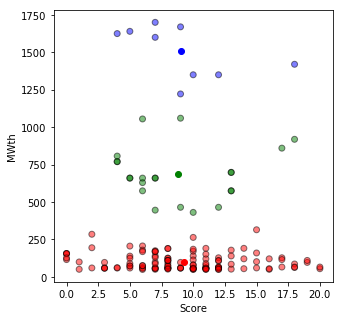

In [31]:
"""
Plotting results of Kmeans
"""
fig = plt.figure(figsize=(5, 5))
colmap = {1: 'r', 2: 'g', 3: 'b'}
colors = list(map(lambda x: colmap[x+1], labels))

plt.scatter(plant_score['Score'], plant_score['MWth'], color=colors, alpha=0.5, edgecolor='k')
for idx, centroid in enumerate(centroids):
    plt.scatter(*centroid, color=colmap[idx+1])

plt.xlabel('Score')
plt.ylabel('MWth')
    
    
plt.show()

In [32]:
new_names = {0:"small plants",1:"medium plants",2:"big plants"}
labeled_plants = plant_score.drop(["MWth"], axis=1)
labeled_plants = labeled_plants.assign(labels=labels)
labeled_plants.replace({"labels":new_names}, inplace=True)

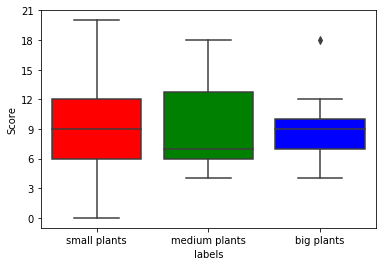

In [47]:
"""
Box plot of Kmeans results
"""
plot = sns.boxplot(x="labels", y="Score", data=labeled_plants, order=["small plants", "medium plants", "big plants"])    
plot.artists[0].set_facecolor('red')
plot.artists[1].set_facecolor('green')
plot.artists[2].set_facecolor('blue')
plt.yticks(np.arange(0, 22, 3))
plt.show()

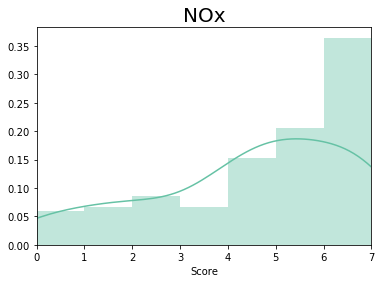

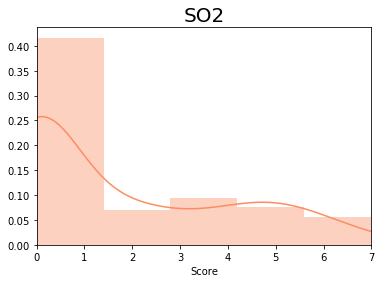

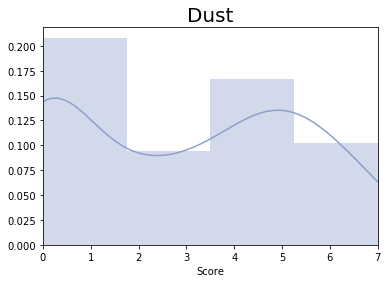

In [34]:
list_of_series_to_show = ["NOx", "SO2", "Dust"]


palette = cycle(sns.color_palette("Set2"))

for series in list_of_series_to_show:
    change_inplants[[series]].apply(lambda x: sns.distplot(x, color=next(palette)))
    plt.title(series, fontsize=20)
    plt.xlabel('Score')
    plt.xlim(0, 7)
    plt.show()

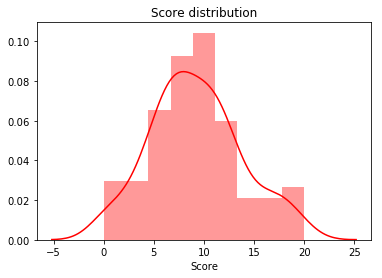

In [43]:
plant_score[["Score"]].apply(lambda x: sns.distplot(x, color = 'r'))
#plt.figure(figsize=(15,5))
plt.title("Score distribution")
plt.show()

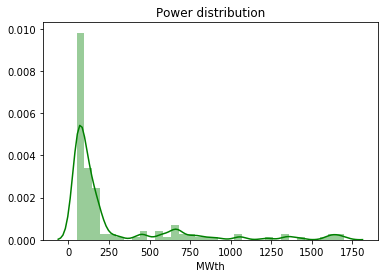

In [44]:
plant_score[["MWth"]].apply(lambda x: sns.distplot(x, color = 'g'))
#plt.figure(figsize=(15,5))
plt.title("Power distribution")
plt.show()

In [37]:
def normality_checker(x, alpha):
    """
    Check if distribution is normal.
    Ho= distribtution is normal
    Input: 1-D data array, alpha - specified threshold value
    Output: message stating wether Ho can be rejected
    """
    k2, p = stats.normaltest(x)
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis can be rejected")
    else:
        print("The null hypothesis cannot be rejected")

In [38]:
normality_checker(plant_score[["Score"]], 0.01)

The null hypothesis cannot be rejected
